In [102]:
from dtw import dtw
import matplotlib.pyplot as plt
import numpy as np
import copy
import librosa
import librosa.display
import IPython.display as ipd

In [54]:
plt.style.use('ggplot')

Loading full sentence using `librosa.load()` function. It returns a numpy array as audio series and a sampling rate.

In [28]:
sample_test_path = 'audio_samples/wav/chai_tea_latte_sentence2.wav'
yTest, srTest = librosa.load(sample_test_path)
ipd.Audio(sample_test_path)

Loading the word to be extracted from the sentence.

In [29]:
sample1_path = 'audio_samples/wav/chai_tea_latte_word.wav'
y1, sr1 = librosa.load(sample1_path)
ipd.Audio(sample1_path)

In order to apply DTW it is important to pre-process the data. In speech recognition data is often represented using the mel-frequency cepstrum and a given time-series signal is represtented using its Mel-frequency cepstrum coefficients (MFCCs). According to Wikipedia, a main goal of utilizing the mel-frequency cepstrum is to represent the data in a way similar to how the human ear perceives sound. It's essentially a spectrum of a spectrum.

In [101]:
#Convert the data to mfcc:
mfcc1 = librosa.feature.mfcc(y = y1, sr = sr1)
mfccTest = librosa.feature.mfcc(y = yTest, sr = srTest)

# Remove mean and normalize each column of MFCC 
def preprocess_mfcc(mfcc):
    mfcc_cp = copy.deepcopy(mfcc)
    for i in range(mfcc.shape[1]):
        mfcc_cp[:,i] = mfcc[:,i] - np.mean(mfcc[:,i])
        mfcc_cp[:,i] = mfcc_cp[:,i]/np.max(np.abs(mfcc_cp[:,i]))
    return mfcc_cp

mfcc1 = preprocess_mfcc(mfcc1)
mfccTest = preprocess_mfcc(mfccTest)

Find MFCCs using `librosa.feature.mfcc()` function. 

In [103]:
#Convert the data to mfcc
mfccTest = preprocess_mfcc(mfccTest)

# length of the word
window_size = mfcc1.shape[1]

Using DTW algorithm with distance metric as $d(x,y) = e^{|x-y|}$

In [99]:
# initialize dists matrix with zeros
dists = np.zeros(mfccTest.shape[1] - window_size)

for i in range(len(dists)):
    mfcci = mfccTest[:,i:i+window_size]
    dist1i = dtw(mfcc1.T, mfcci.T, dist = lambda x, y: np.exp(np.linalg.norm(x - y, ord=1)))[0]
    dists[i] = dist1i

Find minimum distance index and then convert it back to audio signals indices, which we can use to clip the full sentence into only the matched words.

In [35]:
# select minimum distance window
word_match_idx = dists.argmin()
# convert MFCC to time domain
word_match_idx_bnds = np.array([word_match_idx,np.ceil(word_match_idx+window_size)])
samples_per_mfcc = 512
word_samp_bounds = (2/2) + (word_match_idx_bnds*samples_per_mfcc)
word = yTest[int(word_samp_bounds[0]):int(word_samp_bounds[1])]

Plot of distance and minimum distance index

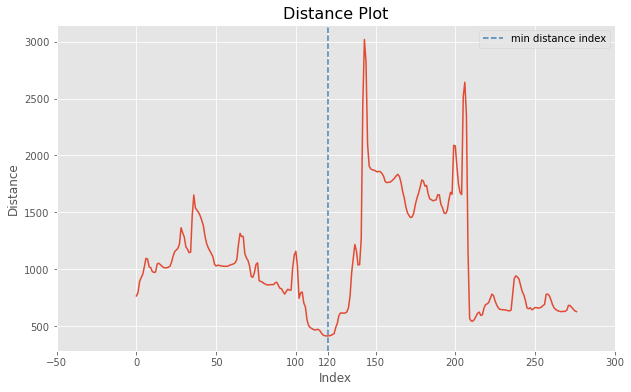

In [93]:
plt.figure(figsize=(10,6))
# plot distance graph
plt.plot(dists)
# plot vertical line at min distance
plt.axvline(x = word_match_idx, color='steelblue', ls='--', label = 'min distance index')
plt.title('Distance Plot', fontsize=16)
plt.xlabel('Index')
plt.ylabel('Distance')
# add additional xtick at min distance index
plt.xticks(list(plt.xticks()[0]) + [word_match_idx])
plt.legend()

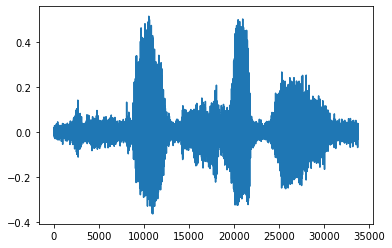

In [36]:
plt.plot(y1)
ipd.Audio(data=y1, rate=sr1)

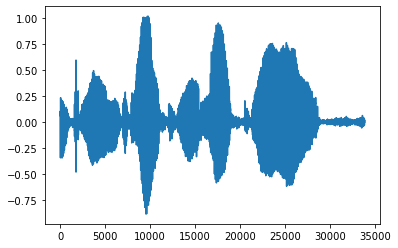

In [40]:
plt.plot(word)
ipd.Audio(data= word, rate=sr1)

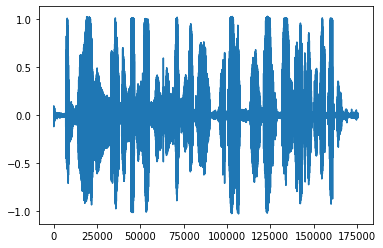

In [39]:
plt.plot(yTest)
ipd.Audio(data = yTest, rate = sr1)